In [ ]:
!pip install --quiet -U optuna neuralforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.8/254.8 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.8 MB/s eta 0:00:00


In [ ]:
import yfinance as yf

# Descargar datos
#tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
tickers = ['AAPL']
Y_df = yf.download(tickers, start='2000-01-01', interval='1mo')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})
Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)

[*********************100%***********************]  1 of 1 completed


In [ ]:
horizon = 6

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
from neuralforecast import NeuralForecast
from neuralforecast.models import TiDE
from neuralforecast.losses.pytorch import SMAPE
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import smape as smape_cv, mape as mape_cv, mae as mae_cv, mse as mse_cv, rmse as rmse_cv
import logging
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Definir la función objetivo para Optuna
def objective(trial):
    # Definir los hiperparámetros a optimizar
    hidden_size = trial.suggest_categorical('hidden_size', [256, 512, 1024])
    input_size = trial.suggest_int('input_size', 1, 3)
    num_encoder_layers = trial.suggest_int('num_encoder_layers', 1, 3)
    num_decoder_layers = trial.suggest_int('num_decoder_layers', 1, 3)
    decoder_output_dim = trial.suggest_categorical('decoder_output_dim', [4, 8, 16, 32])
    temporal_decoder_dim = trial.suggest_categorical('temporal_decoder_dim', [32, 64, 128])
    dropout = trial.suggest_categorical('dropout', [0.0, 0.1, 0.2, 0.3, 0.5])
    layernorm = trial.suggest_categorical('layernorm', [True, False])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    # Crear el modelo TiDE
    model = TiDE(
        h=horizon,
        input_size=input_size,
        hidden_size=hidden_size,
        decoder_output_dim=decoder_output_dim,
        temporal_decoder_dim=temporal_decoder_dim,
        dropout=dropout,
        layernorm=layernorm,
        num_encoder_layers=num_encoder_layers,
        num_decoder_layers=num_decoder_layers,
        learning_rate=learning_rate,
        loss=SMAPE(),
        enable_progress_bar=False
    )

    # Crear y ajustar el modelo
    nf = NeuralForecast(
        models=[model],
        freq='M'
    )

    # Realizar la validación cruzada
    cv_df = nf.cross_validation(Y_df, n_windows=3, step_size=horizon)
    cv_df = cv_df.reset_index()

    # Evaluar las métricas
    evaluation_df = evaluate(cv_df.loc[:, cv_df.columns != 'cutoff'], metrics=[smape_cv, mape_cv, mae_cv, mse_cv, rmse_cv])

    # Obtener las métricas
    smape = evaluation_df[evaluation_df['metric'] == 'smape']['TiDE'].values[0]
    mape = evaluation_df[evaluation_df['metric'] == 'mape']['TiDE'].values[0]
    mae = evaluation_df[evaluation_df['metric'] == 'mae']['TiDE'].values[0]
    mse = evaluation_df[evaluation_df['metric'] == 'mse']['TiDE'].values[0]
    rmse = evaluation_df[evaluation_df['metric'] == 'rmse']['TiDE'].values[0]

    # Almacenar las métricas en los atributos del trial
    trial.set_user_attr('mape', mape)
    trial.set_user_attr('mae', mae)
    trial.set_user_attr('mse', mse)
    trial.set_user_attr('rmse', rmse)

    return smape

# Crear el estudio de Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

best_trial = study.best_trial
mape = best_trial.user_attrs['mape']
mae = best_trial.user_attrs['mae']
mse = best_trial.user_attrs['mse']
rmse = best_trial.user_attrs['rmse']

print("Best hyperparameters:", study.best_params)
print("Best SMAPE:", study.best_value)
print(f'Best MAPE: {mape}')
print(f'Best MAE: {mae}')
print(f'Best MSE: {mse}')
print(f'Best RMSE: {rmse}')


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fab

Best hyperparameters: {'hidden_size': 512, 'input_size': 1, 'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_dim': 128, 'dropout': 0.3, 'layernorm': False, 'learning_rate': 0.0017586835028144334}
Best SMAPE: 0.0368414355645417
Best MAPE: 0.0719581187668758
Best MAE: 14.307002597384983
Best MSE: 348.7008133294811
Best RMSE: 18.673532427729924


In [ ]:
import time

# Crear el modelo TiDE con los mejores hiperparámetros
model_TiDE = TiDE(h=horizon, **study.best_params)
nf = NeuralForecast(models=[model_TiDE], freq='MS')

# Preparar los datos de entrenamiento y prueba
prediction_length = int(len(Y_df)) - horizon
Y_df_real = Y_df[:prediction_length]
Y_df_test = Y_df[prediction_length:]

# Entrenar el modelo (sin medir el tiempo aquí)
nf.fit(Y_df_real)

# Medir el tiempo de predicción
predict_start = time.time()
forecast_df = nf.predict(Y_df_real)
predict_end = time.time()

# Calcular el tiempo de predicción
predict_time = predict_end - predict_start

# Imprimir el tiempo de predicción
print(f"Tiempo de predicción: {predict_time:.2f} segundos")

# Mostrar las predicciones
print(forecast_df)


INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Tiempo de predicción: 0.17 segundos
                  ds        TiDE
unique_id                       
Adj Close 2024-04-01  169.538757
Adj Close 2024-05-01  166.732086
Adj Close 2024-06-01  177.252014
Adj Close 2024-07-01  182.315140
Adj Close 2024-08-01  181.260788
Adj Close 2024-09-01  173.347580


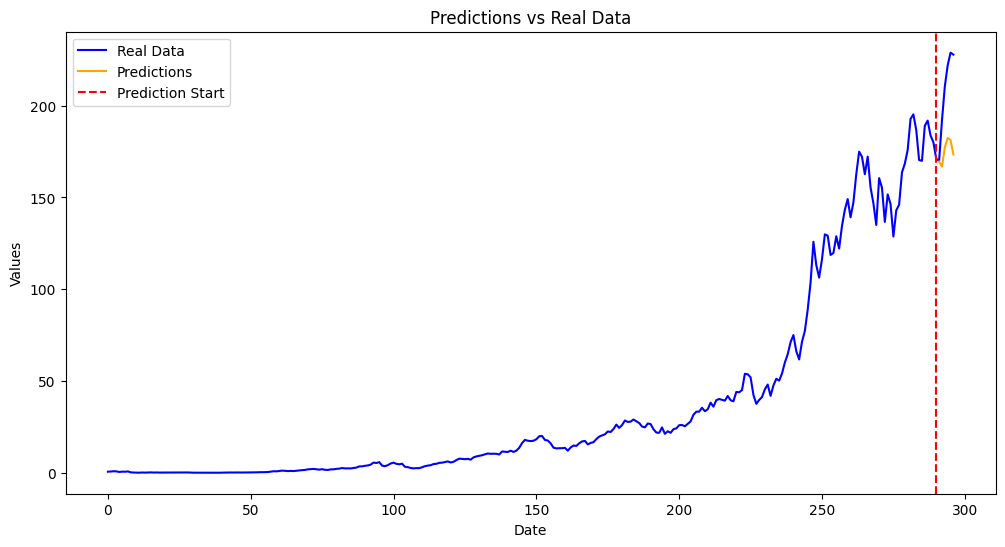

In [ ]:
import matplotlib.pyplot as plt

# Convert to appropriate format for plotting
# Ensure that `forecast_df` has the 'y' column with predictions
forecast_series = forecast_df['TiDE']
real_series = Y_df_test['y']

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(Y_df.index, Y_df['y'], label='Real Data', color='blue')
plt.plot(Y_df.index[prediction_length:], forecast_series, label='Predictions', color='orange')
plt.axvline(x=Y_df.index[prediction_length - 1], color='red', linestyle='--', label='Prediction Start')
plt.title('Predictions vs Real Data')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()
